<a href="https://colab.research.google.com/github/Akhilaprabhu705/ML/blob/main/Time_series_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.DATA COLLECTION**

1.1 Importing all the required libraries and setting random seed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os

seed = 42

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

1.2 Here we are fetching the dataset, housing_power_consumption.txt directly to our environmen from kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Dataset downloaded to:", path)

100%|██████████| 19.4M/19.4M [00:00<00:00, 121MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/uciml/electric-power-consumption-data-set/versions/1


The dataset is read and its shape, info(first 5 rows, all columns) are printed


In [ ]:
file_path = os.path.join(path, "household_power_consumption.txt")

df = pd.read_csv(
    file_path,
    sep=';',
    na_values='?',
    low_memory=False
)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#  **2. DATA PREPROCESSING**

2.1 In this step missing and duplicate values are checked, percentage of missing values for each column is calculated

In [ ]:
missing_summary = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100
})

print(missing_summary[missing_summary['Missing Values'] > 0])

print("Duplicate rows:", df.duplicated().sum())

                       Missing Values  Missing Percentage
Global_active_power             25979            1.251844
Global_reactive_power           25979            1.251844
Voltage                         25979            1.251844
Global_intensity                25979            1.251844
Sub_metering_1                  25979            1.251844
Sub_metering_2                  25979            1.251844
Sub_metering_3                  25979            1.251844
Duplicate rows: 0


2.2 converting text based columns(except date, time) to nnumeric format

In [ ]:
for col in df.columns:
    if col not in ['Date','Time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

*   Date & Time columns are merged into single column.
*  It is then set as the index.
*  To reduce noise the data is resampled to hourly basis.
*  Missing values are then handeled using forward backward filling





In [ ]:
df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df_hourly = df.resample('h').mean()
df_hourly = df_hourly.ffill().bfill()

df_hourly['Hour'] = df_hourly.index.hour
df_hourly['Day'] = df_hourly.index.day
df_hourly['Month'] = df_hourly.index.month
df_hourly['DayOfWeek'] = df_hourly.index.dayofweek

# **3. EXPLORATORY DATA ANALYSIS(EDA)**

3.1 Line Plot of Global Active Power, this graph shows us how the consumption changes over time.

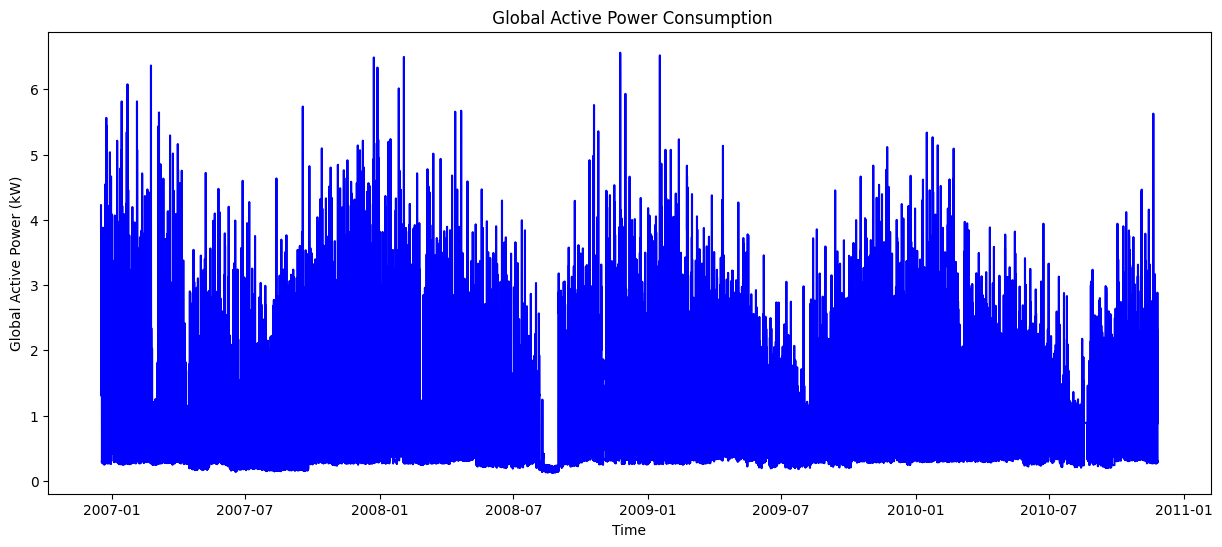

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_hourly['Global_active_power'], color='blue')
plt.title(" Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()

3.2 Histogram to analyze the distribution, how frequently certain power values occur   

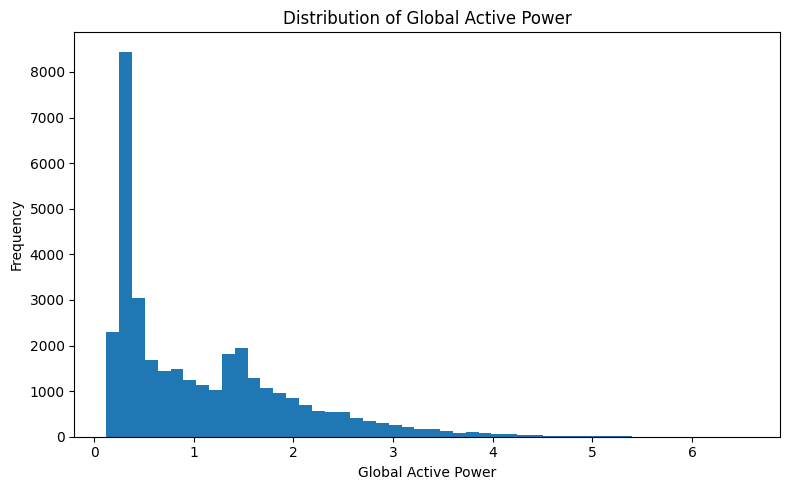

In [ ]:
plt.figure(figsize=(8,5))

plt.hist(df_hourly['Global_active_power'], bins=50)

plt.title("Distribution of Global Active Power")
plt.xlabel("Global Active Power")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


3.3 Bar Chart depicting monthly average power consumption

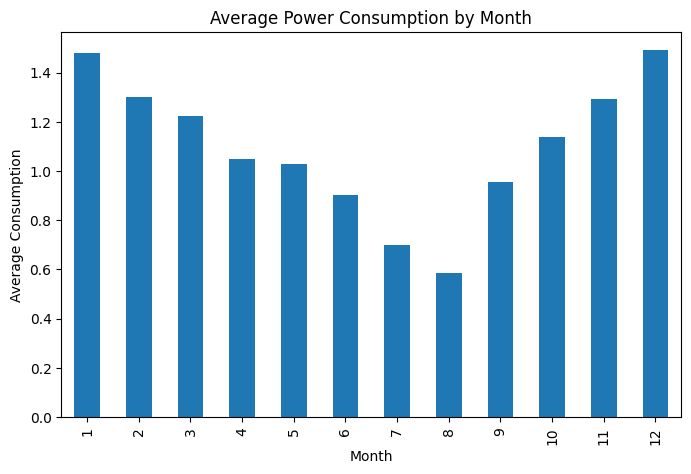

In [ ]:
monthly_avg = df_hourly.groupby('Month')['Global_active_power'].mean()

plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar')
plt.title("Average Power Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Average Consumption")
plt.show()


3.4 Line Plot showing average global active power on hourly basis

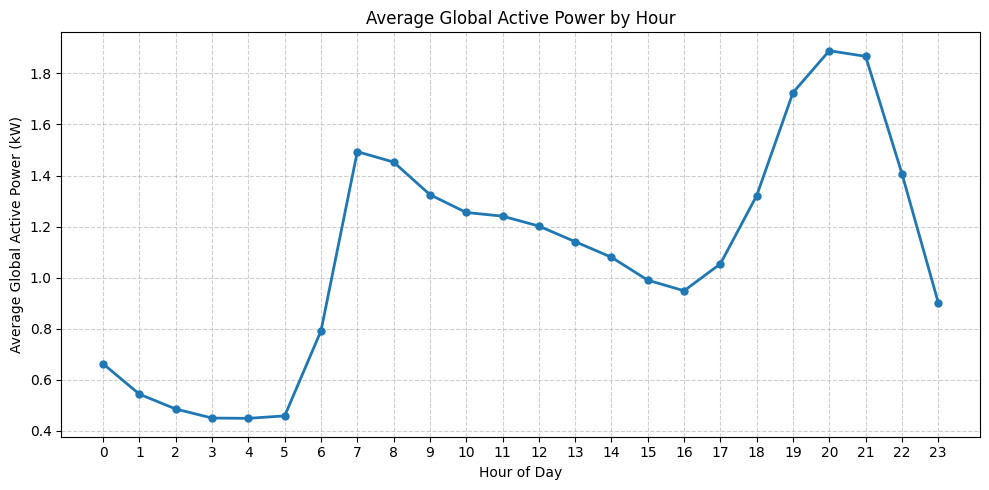

In [ ]:
hourly_avg = df_hourly.groupby('Hour')['Global_active_power'].mean()
plt.figure(figsize=(10,5))

plt.plot(
    hourly_avg.index,
    hourly_avg.values,
    marker='o',
    linewidth=2,
    markersize=5
)


plt.title("Average Global Active Power by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Global Active Power (kW)")


plt.xticks(range(0, 24))


plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


3.5 Box Plot showing the distribution of consumption per hour

<Figure size 1000x600 with 0 Axes>

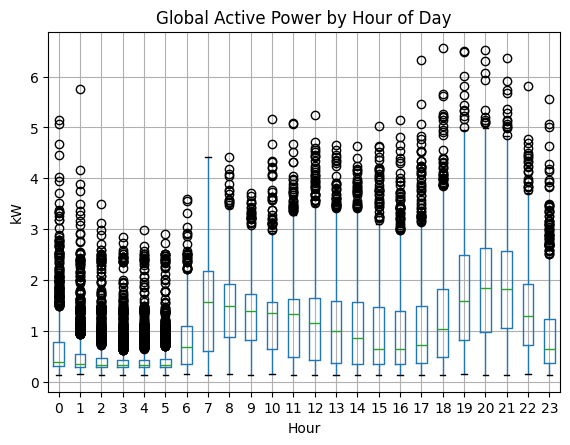

In [ ]:
plt.figure(figsize=(10,6))
df_hourly.boxplot(column='Global_active_power', by='Hour')
plt.title("Global Active Power by Hour of Day")
plt.suptitle("")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.show()


In the below code we are seperating the target and feature, Global_active_power is the target variable. Here the datset is chronologically split in 80% training and 20 % testing.


  



In [ ]:
target = 'Global_active_power'
train_size = int(len(df_hourly) * 0.8)

train = df_hourly[:train_size]
test = df_hourly[train_size:]

In the below code we are using lag,it adds the previous values of the target variable as new columns which will help the model to learn patterns from the past hourrs.

In [ ]:
# Here we are creatinge lag features for forecasting
def create_lag_features(df, target, lags=24):
    df_lag = df.copy()
    for lag in range(1, lags+1):
        df_lag[f'lag_{lag}'] = df_lag[target].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag

df_lag = create_lag_features(df_hourly, target, lags=24)


The lagged dataset is split in a chronological order as mentioned (80% training and 20% testing)

In [ ]:
split_index = int(len(df_lag) * 0.8)

train = df_lag.iloc[:split_index]
test = df_lag.iloc[split_index:]

X_train = train.drop(target, axis=1)
y_train = train[target]

X_test = test.drop(target, axis=1)
y_test = test[target]


# **4. MODEL SELECTION AND IMPLEMENTATION**

4.1 Random Forest Regression, tree-based regression model, it uses lag features. This model predicts Global_active_power on the test set ypred_rf.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

ypred_rf = rf_model.predict(X_test)


4.2 XGBoost - Gradient Boosting Regression model which uses lag features and generates forecast on the test set y_pred_xgb.

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    subsample=1.0,
    colsample_bytree=1.0,
    n_jobs=-1,
    max_depth=6,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


4.3 Sarimax - Statistical model for time series forecasting.This model produces the forecast in y_pred_sarima.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False,
    initialization='approximate_diffuse'
)

#we are using maxiter=50 so that the execution time is less
sarima_fit = sarima_model.fit(disp=False, method='lbfgs', maxiter=50)
y_pred_sarima = sarima_fit.forecast(steps=len(y_test), exog=X_test)


# **6. MODEL EVALUATION**

Metrics is calculated for all the 3 models used.

1.   MAE - Mean Absolute Error
2.   RMSE - Root Mean Squared Error
1.   R^2 Score - Variance explained by the model.



from the evaluation metrcs we see that Random Forest is the best model, XGBoost is the second best and least is Sarimax.(detailed explanation in th report)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

results = {
    'SARIMA': {
        'MAE': mean_absolute_error(y_test, y_pred_sarima),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_sarima)),
        'R2': r2_score(y_test, y_pred_sarima)
    },
    'RF': {
        'MAE': mean_absolute_error(y_test, ypred_rf),
        'RMSE': np.sqrt(mean_squared_error(y_test, ypred_rf)),
        'R2': r2_score(y_test, ypred_rf)
    },
    'XGBoost': {
        'MAE': mean_absolute_error(y_test, y_pred_xgb),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        'R2': r2_score(y_test, y_pred_xgb)
    }
}

results_df = pd.DataFrame(results).T
print(results_df)


              MAE      RMSE        R2
SARIMA   0.018398  0.024786  0.998846
RF       0.012892  0.021131  0.999161
XGBoost  0.012310  0.022065  0.999086


6.1 Actual vs Predicted of SARIMA, Black line represents actual consumption and blue represents predicted.

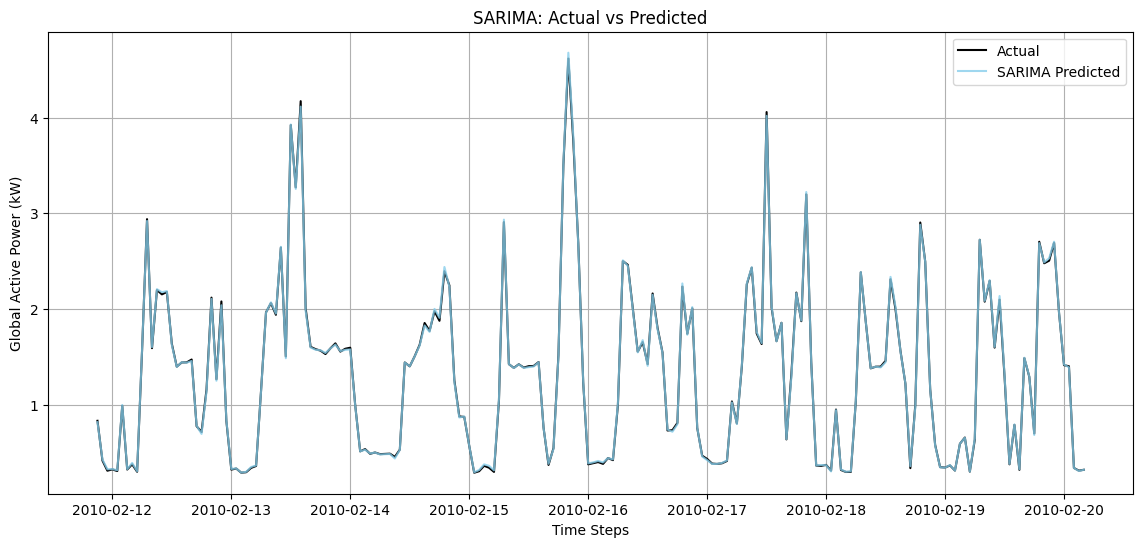

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:200], label='Actual', color='black')
plt.plot(y_pred_sarima[:200], label='SARIMA Predicted', color='skyblue', alpha=0.8)

plt.title("SARIMA: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

6.2 Actual vs Predicted of RANDOM FOREST REGRESSOR, Black line represents actual consumption and blue represents predicted.

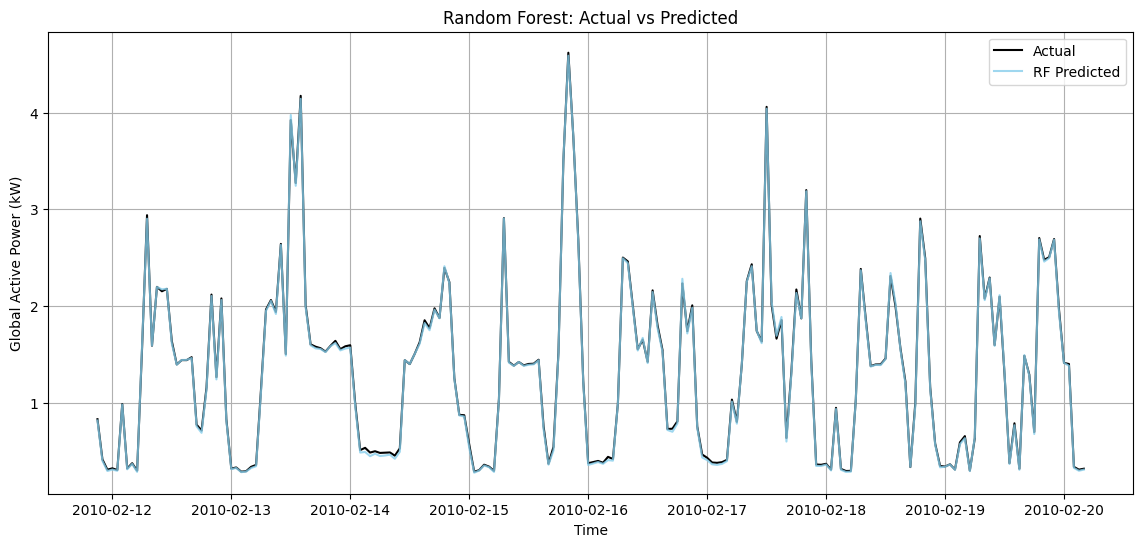

In [ ]:
plt.figure(figsize=(14,6))

plt.plot(y_test.index[:200], y_test.values[:200],label='Actual', color='black')

plt.plot(y_test.index[:200], ypred_rf[:200],label='RF Predicted', color='skyblue', alpha=0.8)

plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.show()


6.3 Actual vs Predicted of XGBoost, Black line represents actual consumption and blue represents predicted.

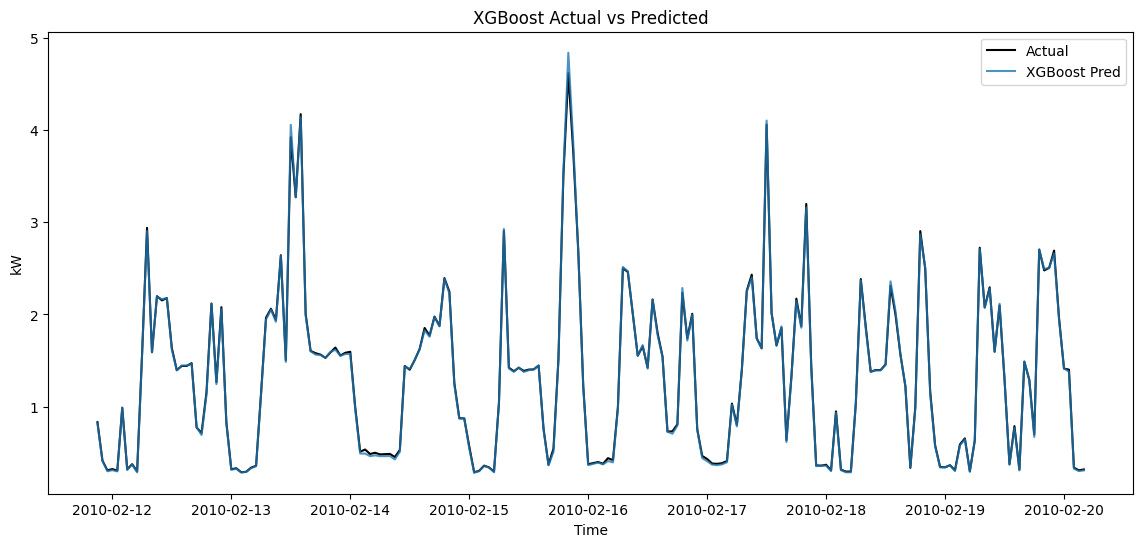

In [ ]:
plt.figure(figsize=(14,6))

plt.plot(y_test.index[:200], y_test.values[:200], label='Actual', color='black')
plt.plot(y_test.index[:200], y_pred_xgb[:200], label='XGBoost Pred', alpha=0.8)

plt.title("XGBoost Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.show()